In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# **Preprocessing**
**This defines a function to preprocess the data.**

In [6]:
# Load and preprocess data
def preprocess_data(data):
    # Feature engineering

    #This extracts the title (Mr., Mrs., etc.) from the 'Name' column using a regular expression.
    data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

    #These lines create new features: 'FamilySize' (number of family members + 1) and 'IsAlone'
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
    data['IsAlone'] = (data['FamilySize'] == 1).astype(int)

    # Encoding categorical variables
    data['Sex'] = data['Sex'].map({'female': 0, 'male': 1})
    data['Embarked'] = data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

    #This selects the features we'll use and creates numpy arrays X (features) and y (target).
    features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'IsAlone']

    X = data[features].values
    y = data['Survived'].values

    # Impute missing values
    for col in range(X.shape[1]):
        mask = np.isnan(X[:, col])
        X[mask, col] = np.mean(X[~mask, col])

    return X, y

In [7]:
dataset = pd.read_csv('/content/titanic.csv')
X, y = preprocess_data(dataset)

In [8]:
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,0.0,Mr,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,1.0,Mrs,2,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0.0,Miss,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,0.0,Mrs,2,0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,0.0,Mr,1,1


In [9]:
# Normalize features
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X = (X - X_mean) / X_std

# split data

In [10]:
# Split data
np.random.seed(42)
indices = np.random.permutation(len(X))
split = int(0.8 * len(X))
X_train, X_test = X[indices[:split]], X[indices[split:]]
y_train, y_test = y[indices[:split]], y[indices[split:]]

In [11]:
def euclidean_distance(X1, X2):
    return np.sqrt(np.sum((X1 - X2)**2, axis=1))

In [12]:
def get_neighbors(X_train, y_train, test_row, k):
    distances = euclidean_distance(X_train, test_row)
    indices = np.argsort(distances)[:k]
    return y_train[indices]

In [13]:
def predict_classification(X_train, y_train, test_row, k):
    neighbors = get_neighbors(X_train, y_train, test_row, k)
    return np.bincount(neighbors).argmax()

In [14]:
def knn_predict(X_train, y_train, X_test, k):
    return np.array([predict_classification(X_train, y_train, row, k) for row in X_test])


In [15]:
def cross_val_score_manual(X, y, k, cv=10):
    fold_size = len(X) // cv
    scores = []
    for i in range(cv):
        start = i * fold_size
        end = (i + 1) * fold_size
        X_val, y_val = X[start:end], y[start:end]
        X_train = np.concatenate([X[:start], X[end:]], axis=0)
        y_train = np.concatenate([y[:start], y[end:]], axis=0)
        y_pred = knn_predict(X_train, y_train, X_val, k)
        scores.append(np.mean(y_pred == y_val))
    return np.mean(scores)

Optimal k: 12


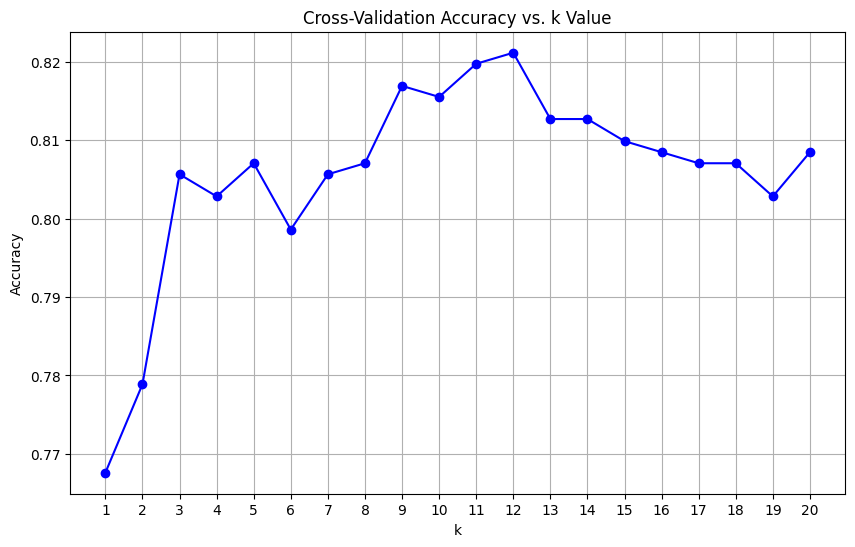

Test set accuracy with optimal k (12): 0.8044692737430168


In [16]:
# Find optimal k
k_values = range(1, 21)
cv_scores = [cross_val_score_manual(X_train, y_train, k) for k in k_values]
optimal_k = k_values[np.argmax(cv_scores)]
print(f"Optimal k: {optimal_k}")

# Plot CV scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_scores, marker='o', linestyle='-', color='b')
plt.title('Cross-Validation Accuracy vs. k Value')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# Final evaluation
y_pred_test = knn_predict(X_train, y_train, X_test, optimal_k)
accuracy_test = np.mean(y_pred_test == y_test)
print(f"Test set accuracy with optimal k ({optimal_k}): {accuracy_test}")